# Generative Adversarial Network
(GAN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.layers import Conv2D, Flatten, MaxPooling2D, Reshape

from keras.optimizers import Adam

In [4]:
from keras.datasets import mnist

In [5]:
discriminator = Sequential()

discriminator.add(Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D())

discriminator.add(Conv2D(filters=6, kernel_size=(3, 3), strides=(1, 1), activation='relu',))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D())

discriminator.add(Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), activation='relu',))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(filters=24, kernel_size=(3, 3), strides=(1, 1), activation='relu',))
discriminator.add(Dropout(0.2))

discriminator.add(Flatten())

discriminator.add(Dense(units=64, activation='relu'))
discriminator.add(Dropout(0.2))
discriminator.add(Dense(units=1, activation='softmax'))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])

In [6]:
noise_dim = 100

In [7]:
generator = Sequential()

generator.add(Dense(units=128, activation='relu', input_dim=noise_dim))
generator.add(BatchNormalization())
generator.add(Dropout(0.2))

generator.add(Dense(units=256, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dropout(0.2))

generator.add(Dense(units=512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dropout(0.2))

generator.add(Dense(units=784, activation='relu'))
generator.compile(loss='mae', optimizer='adam')

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 256)              

In [8]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 3)         30        
                                                                 
 dropout (Dropout)           (None, 26, 26, 3)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 3)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 6)         168       
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 6)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 6)           0         
 g2D)                                                   

In [9]:
discriminator.trainable = False
gan = Sequential()

gan.add(generator)
gan.add(Reshape(target_shape=(28, 28, 1)))
gan.add(discriminator)

gan.compile(loss='binary_crossentropy', optimizer=Adam(1e-4))

gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 784)               583312    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 sequential (Sequential)     (None, 1)                 5139      
                                                                 
Total params: 588451 (2.24 MB)
Trainable params: 581520 (2.22 MB)
Non-trainable params: 6931 (27.07 KB)
_________________________________________________________________


In [10]:
def plot_loss(losses):
    d_losses = [v for v in losses['D']]
    g_losses = [v for v in losses['G']]
    plt.figure(figsize=(10, 8))
    plt.plot(d_losses, label='Discriminator Loss', c='g')
    plt.plot(g_losses, label='Generator Loss', c='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 384ms/step


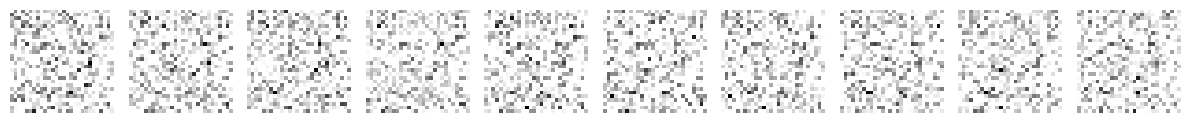

In [11]:
plot_generated()

In [12]:
losses ={
    'D':[],
    'G':[]
}

In [13]:
(x,_),(_, _)= mnist.load_data()

In [14]:
x.shape

(60000, 28, 28)

In [46]:
x = x.reshape(60000,28,28,1)

In [47]:
60000//1000

60

In [54]:
def fit(epochs=20,plot_interval=5,batch_size=1000):
    no_of_batches=x.shape[0]//batch_size
    for i in tqdm(range(1,epochs+1),desc='Total progress'):
        print(f'-------Epoch {i}-------')
        for j in range(no_of_batches):
             
                
            #taking real images of half batch size
            batch_images =x[np.random.randint(0,60_000,size=batch_size)]
            
            #taking fake images of half abtch size
            noisy_images=np.random.normal(0,1,size=(batch_size,noise_dim))
            generated_images=generator.predict(noisy_images,verbose=0)
            generated_images=generated_images.reshape(batch_size,28,28,1)
            
            #preparing data with half fake and half real image
            x_train = np.concatenate((batch_images,generated_images))
            y_train = np.zeros(batch_size*2)
            y_train[:batch_size] = 1
           
            #training Discriminator
            discriminator.trainable = True
            dis_loss =discriminator.train_on_batch(x_train,y_train)
            
            #Training GAN(by freezing discriminator)
            discriminator.trainable=False
            x_gan = np.random.normal(0,1,size=(batch_size,noise_dim))
            y_gan =np.ones(batch_size)
            gan_loss = gan.train_on_batch(x_gan,y_gan)
            
        losses['D'].append(dis_loss)
        losses['G'].append(gan_loss)
        if i == 1 or i% plot_interval == 0:
            plot_generated()
        plot_loss(losses)
            
            

Total progress:   0%|                                                                           | 0/20 [00:00<?, ?it/s]

-------Epoch 1-------
1/1 [==============================] - 0s 32ms/step


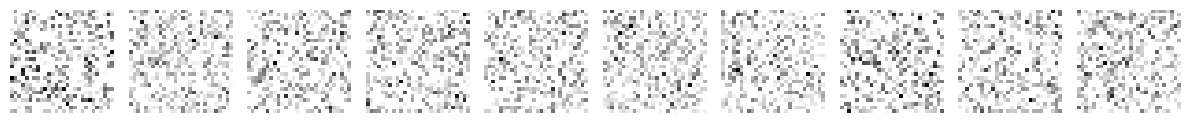

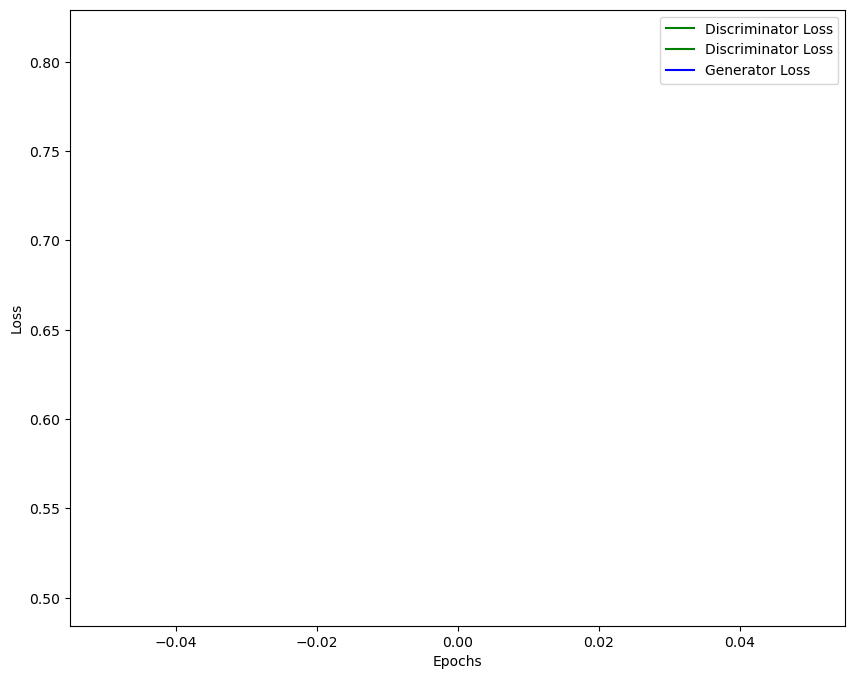

Total progress:   5%|███▎                                                               | 1/20 [00:58<18:34, 58.64s/it]

-------Epoch 2-------


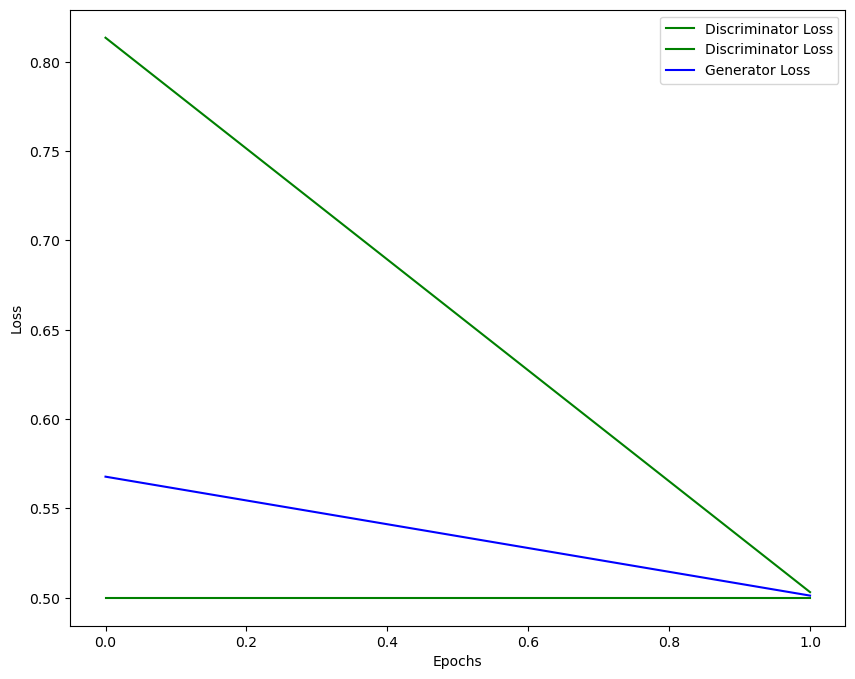

Total progress:  10%|██████▋                                                            | 2/20 [01:53<16:51, 56.20s/it]

-------Epoch 3-------


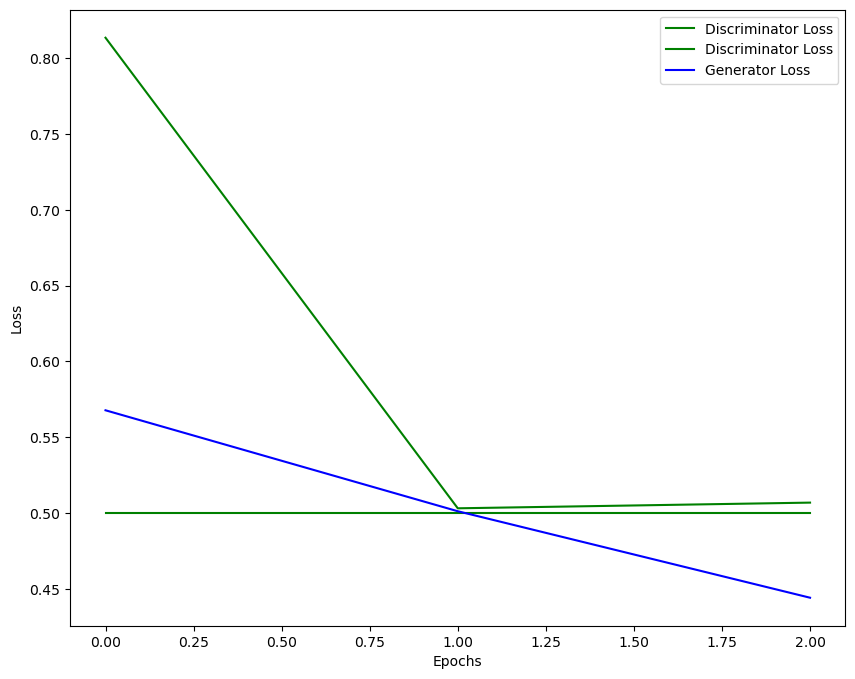

Total progress:  15%|██████████                                                         | 3/20 [02:56<16:50, 59.44s/it]

-------Epoch 4-------


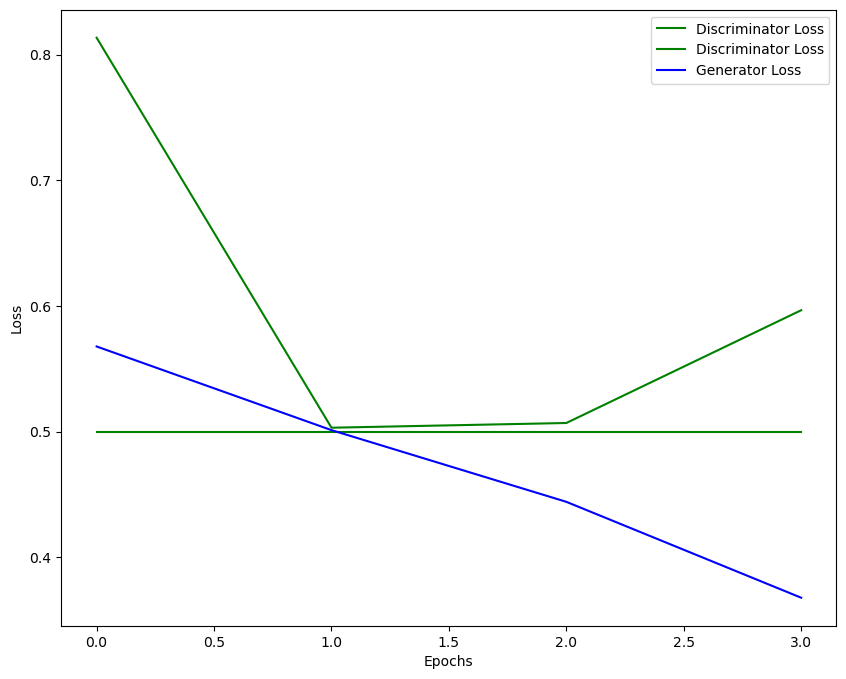

Total progress:  20%|█████████████▍                                                     | 4/20 [04:08<17:10, 64.42s/it]

-------Epoch 5-------
1/1 [==============================] - 0s 64ms/step


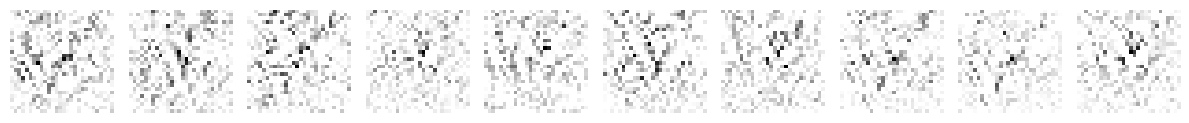

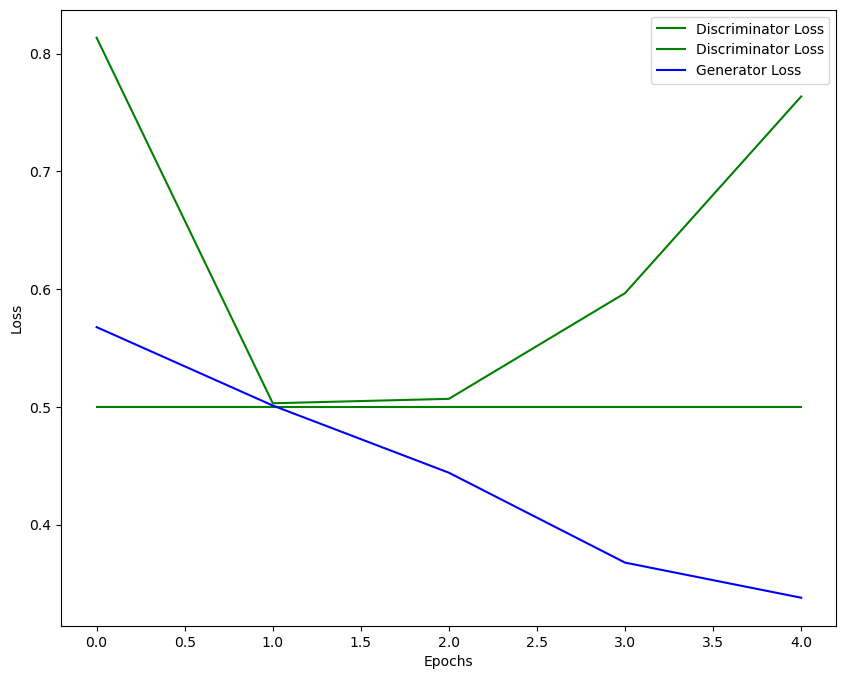

Total progress:  25%|████████████████▊                                                  | 5/20 [05:29<17:38, 70.57s/it]

-------Epoch 6-------


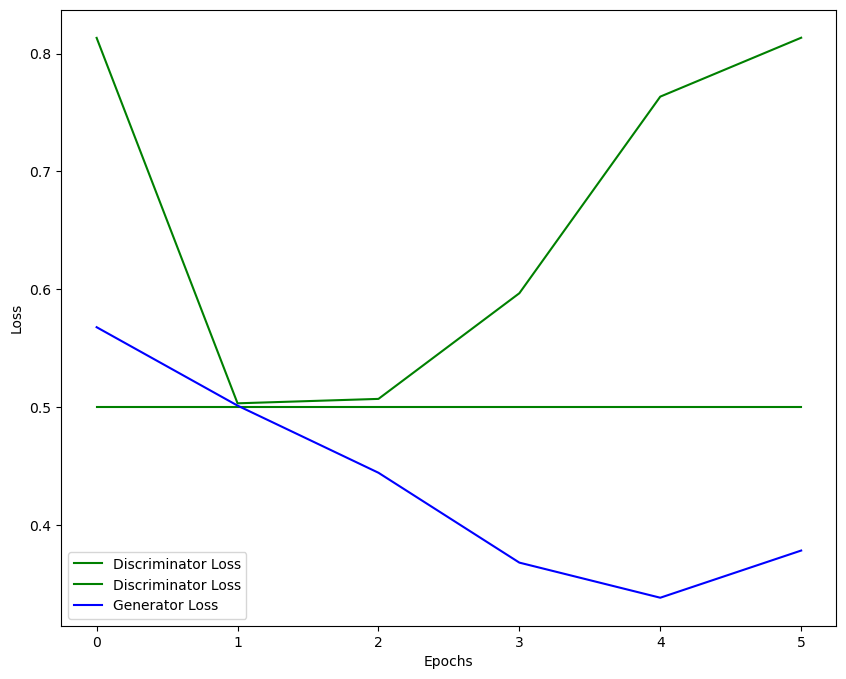

Total progress:  30%|████████████████████                                               | 6/20 [06:55<17:36, 75.49s/it]

-------Epoch 7-------


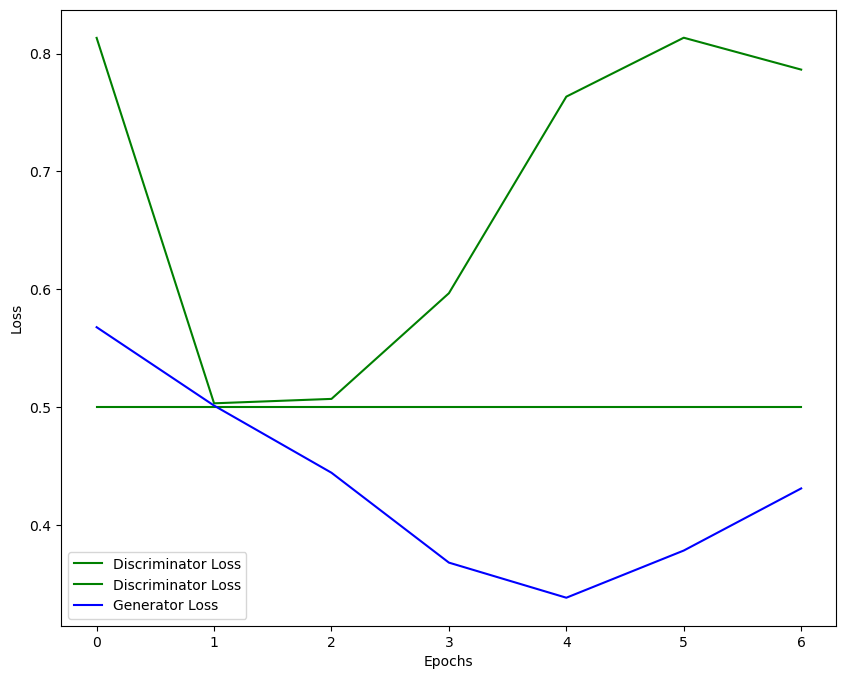

Total progress:  35%|███████████████████████▍                                           | 7/20 [08:08<16:11, 74.69s/it]

-------Epoch 8-------


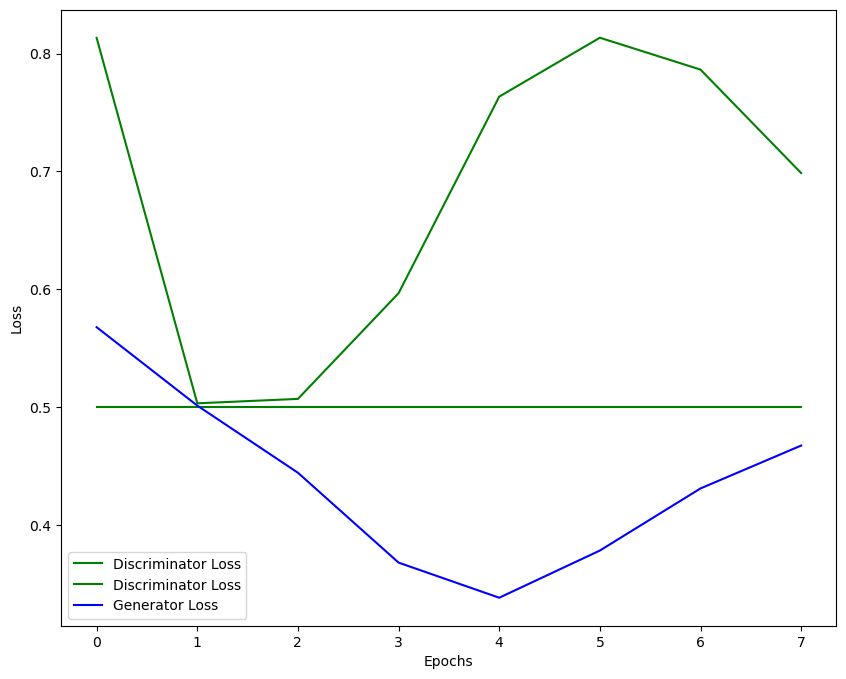

Total progress:  40%|██████████████████████████▊                                        | 8/20 [09:32<15:32, 77.67s/it]

-------Epoch 9-------


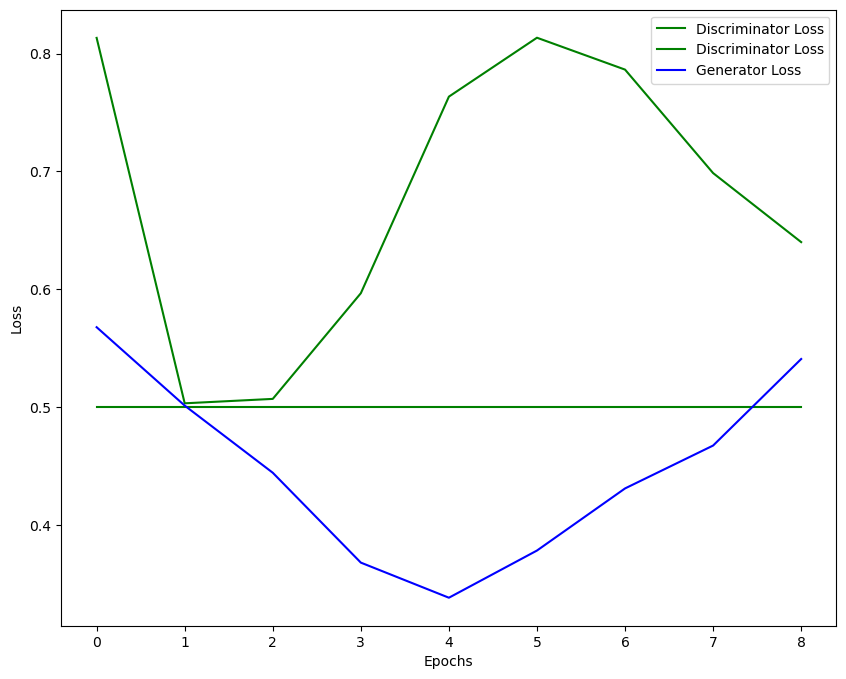

Total progress:  45%|██████████████████████████████▏                                    | 9/20 [10:39<13:40, 74.61s/it]

-------Epoch 10-------
1/1 [==============================] - 0s 49ms/step


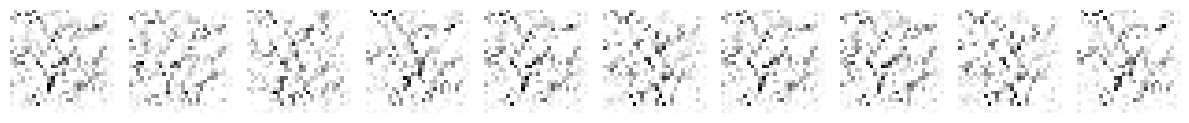

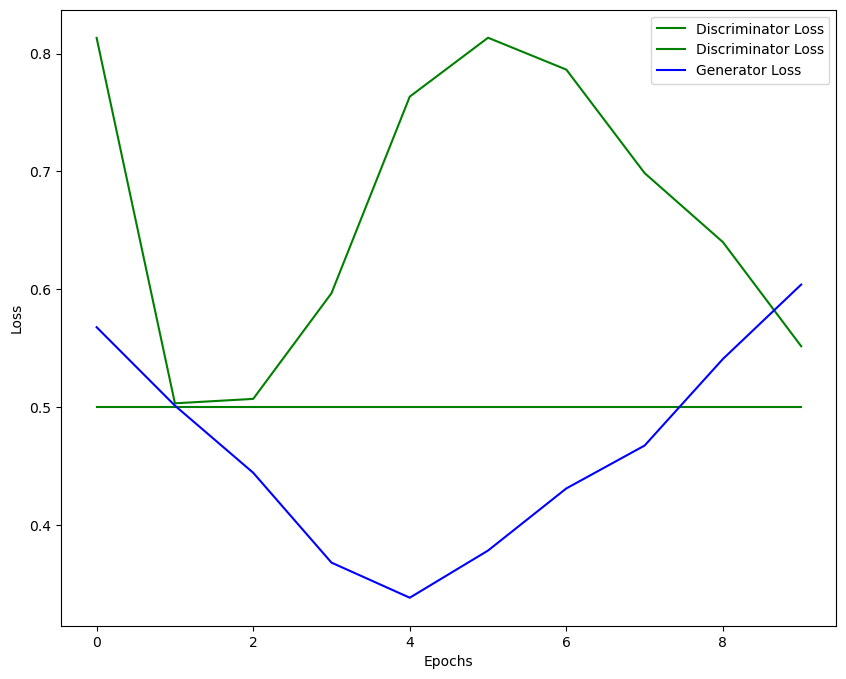

Total progress:  50%|█████████████████████████████████                                 | 10/20 [11:46<12:00, 72.05s/it]

-------Epoch 11-------


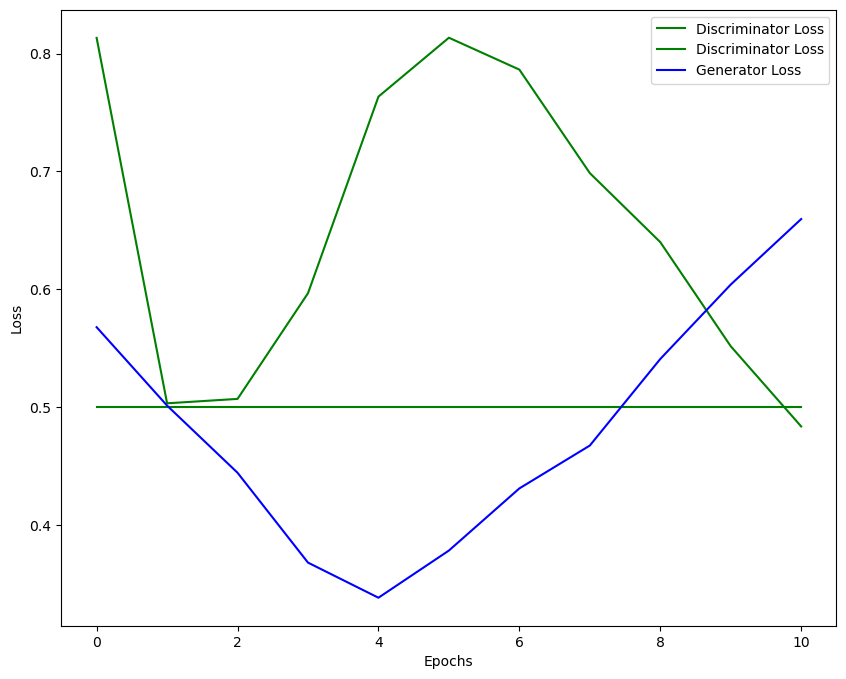

Total progress:  55%|████████████████████████████████████▎                             | 11/20 [12:46<10:15, 68.41s/it]

-------Epoch 12-------


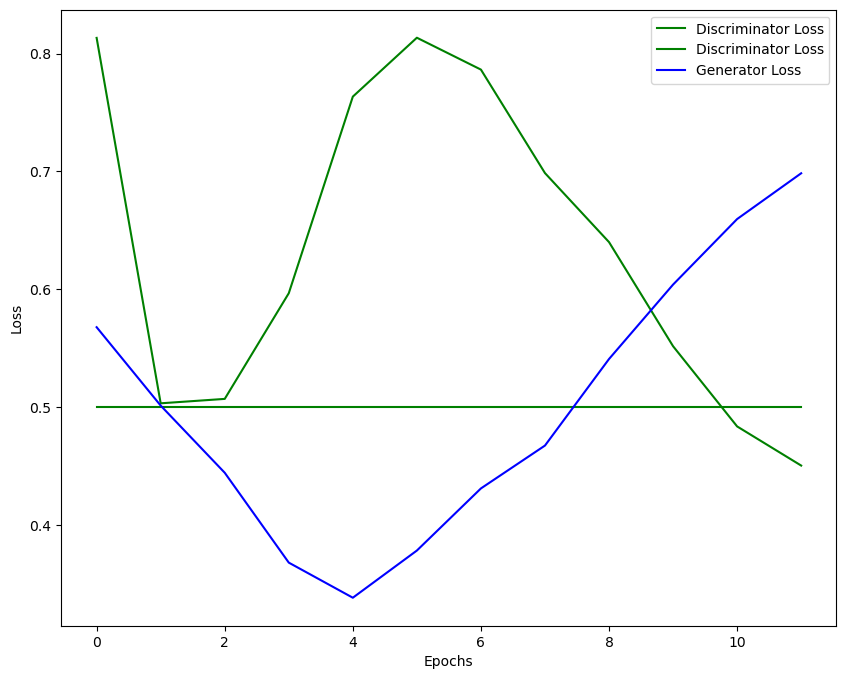

Total progress:  60%|███████████████████████████████████████▌                          | 12/20 [13:46<08:48, 66.00s/it]

-------Epoch 13-------


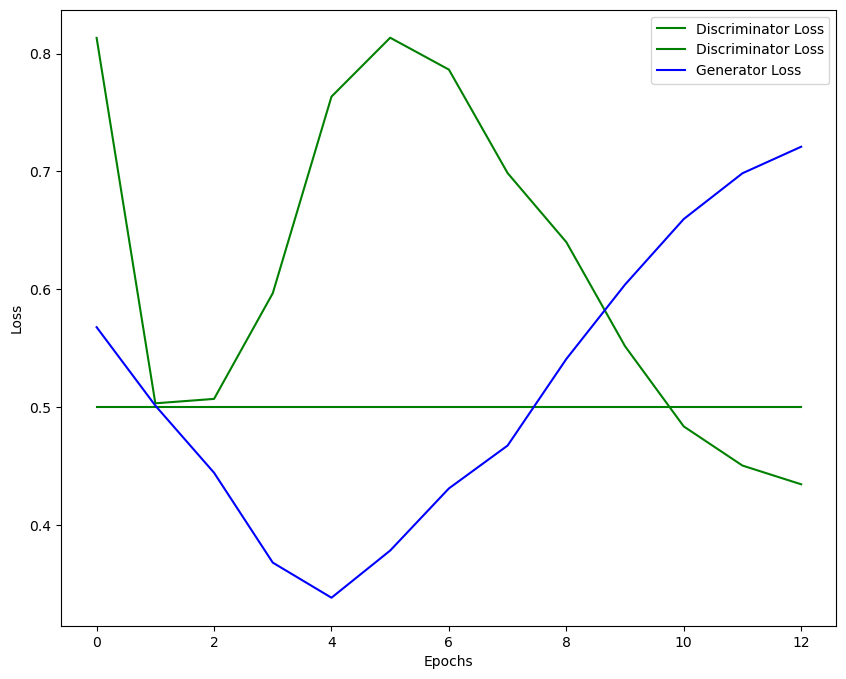

Total progress:  65%|██████████████████████████████████████████▉                       | 13/20 [14:54<07:46, 66.58s/it]

-------Epoch 14-------


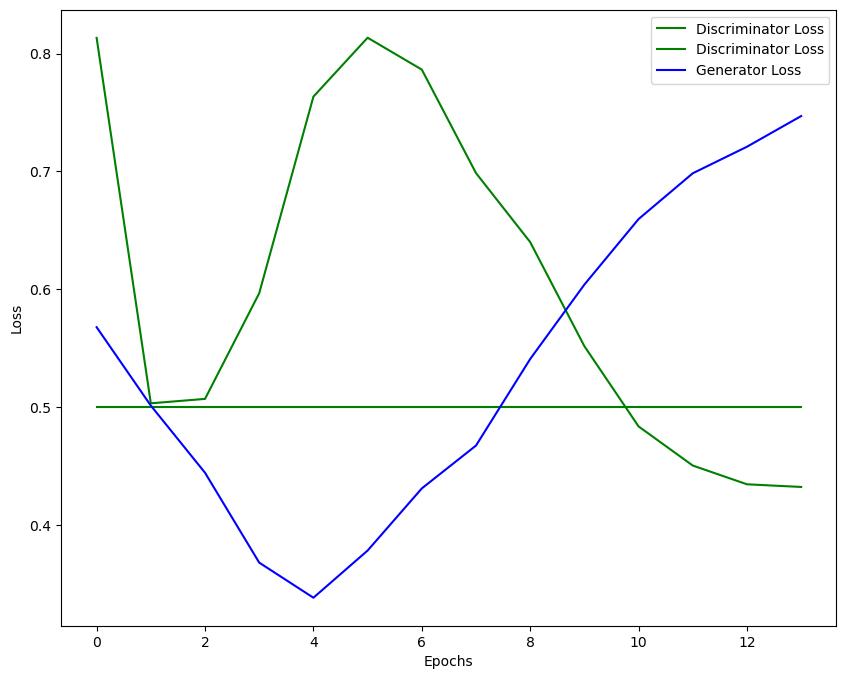

Total progress:  70%|██████████████████████████████████████████████▏                   | 14/20 [15:56<06:30, 65.14s/it]

-------Epoch 15-------
1/1 [==============================] - 0s 46ms/step


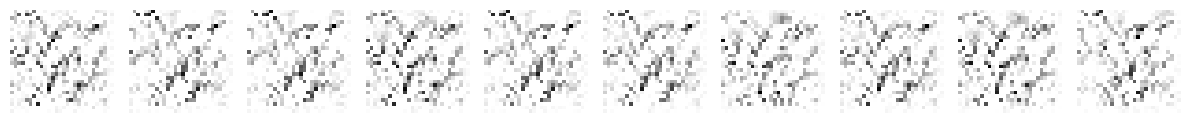

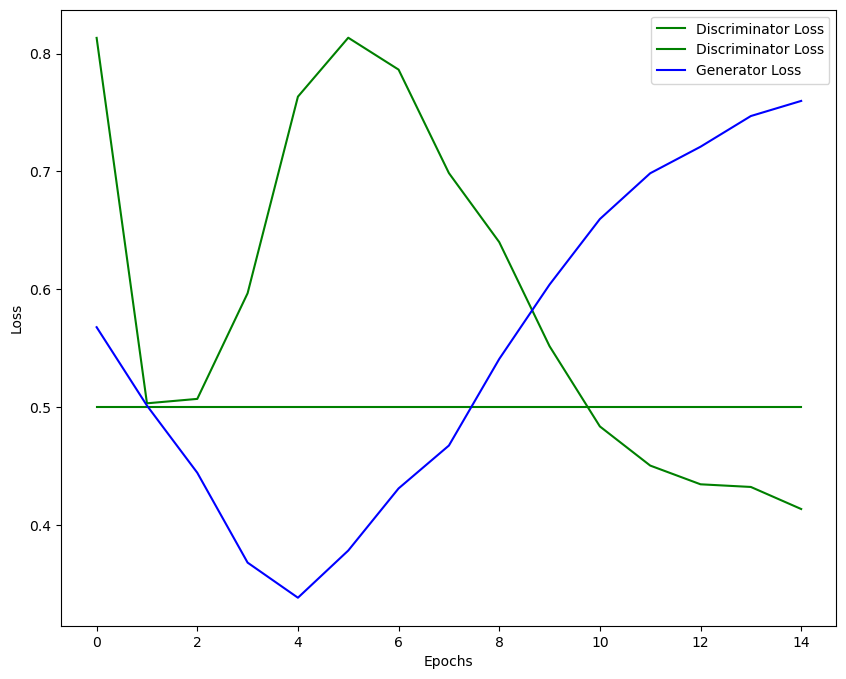

Total progress:  75%|█████████████████████████████████████████████████▌                | 15/20 [17:01<05:25, 65.05s/it]

-------Epoch 16-------


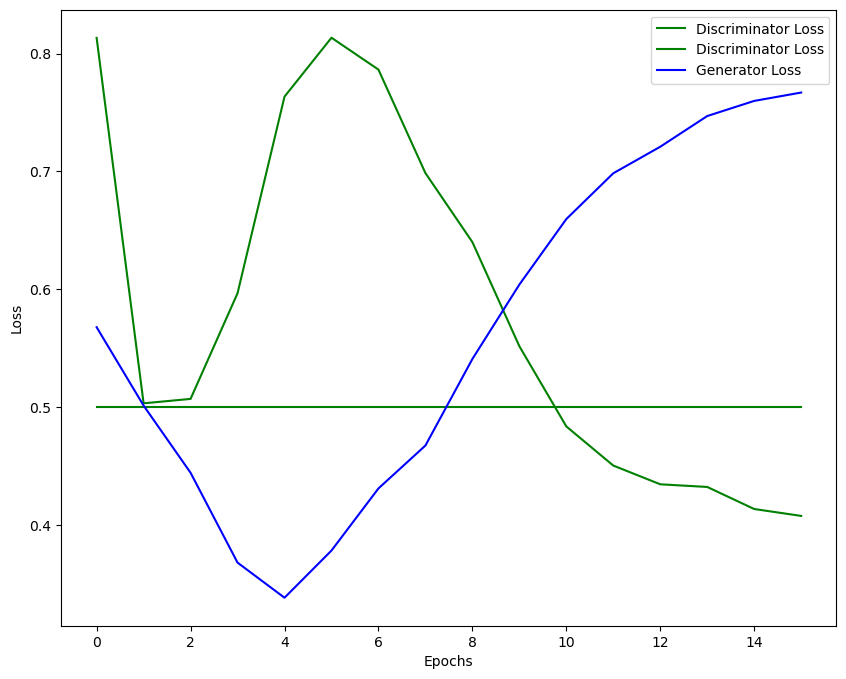

Total progress:  80%|████████████████████████████████████████████████████▊             | 16/20 [18:17<04:33, 68.47s/it]

-------Epoch 17-------


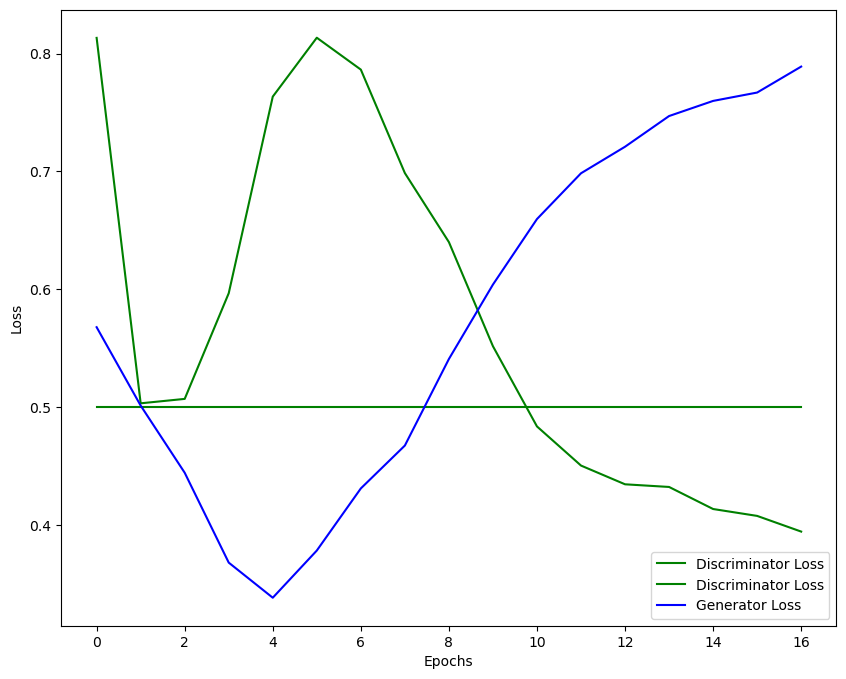

Total progress:  85%|████████████████████████████████████████████████████████          | 17/20 [19:27<03:26, 68.67s/it]

-------Epoch 18-------


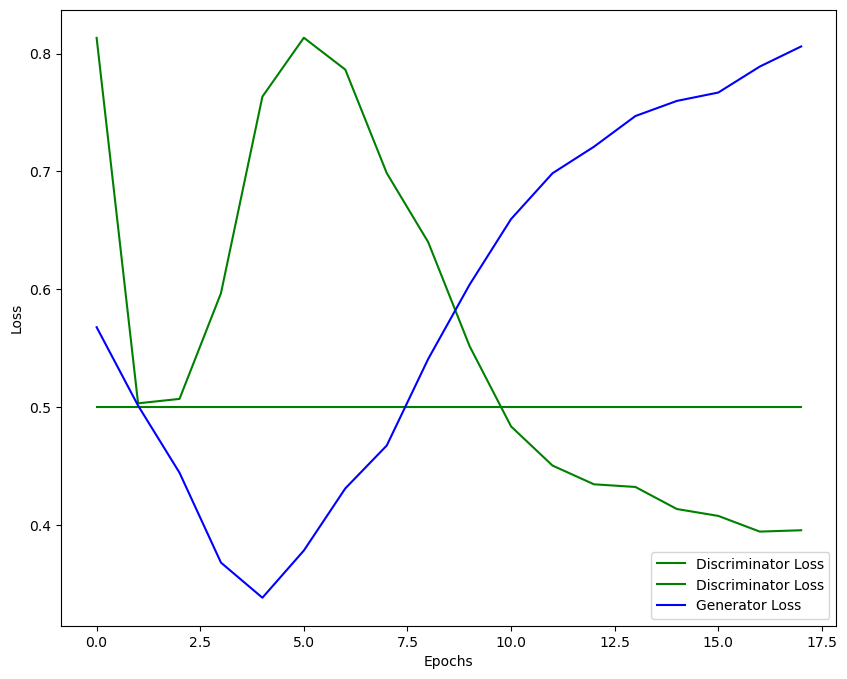

Total progress:  90%|███████████████████████████████████████████████████████████▍      | 18/20 [20:48<02:25, 72.60s/it]

-------Epoch 19-------


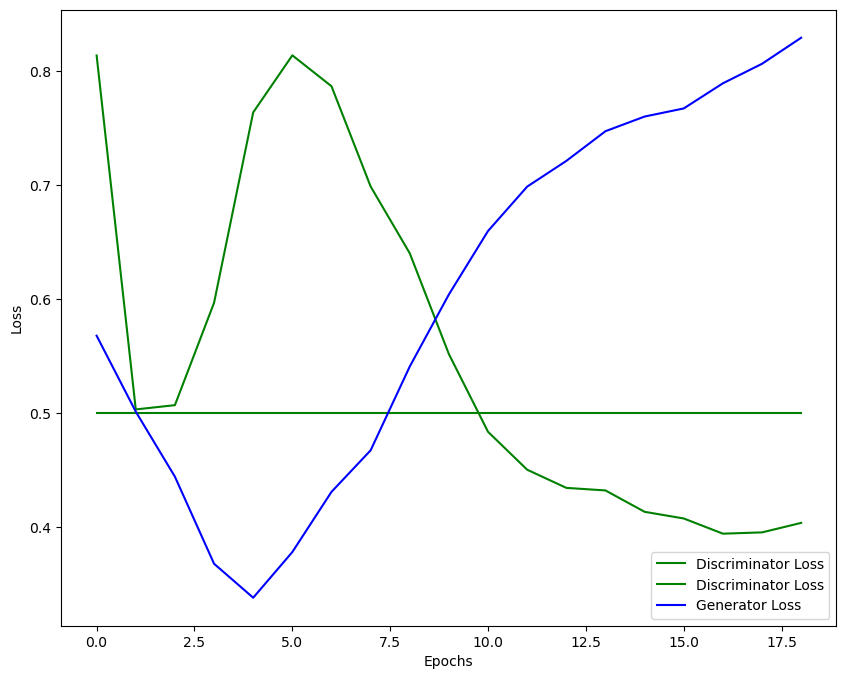

Total progress:  95%|██████████████████████████████████████████████████████████████▋   | 19/20 [22:34<01:22, 82.64s/it]

-------Epoch 20-------
1/1 [==============================] - 0s 267ms/step


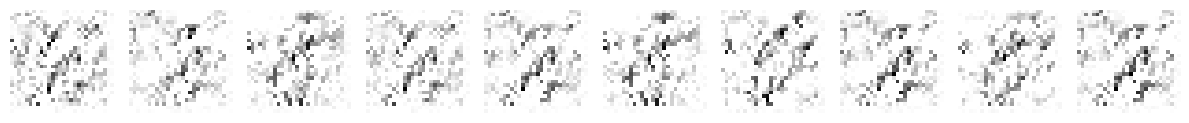

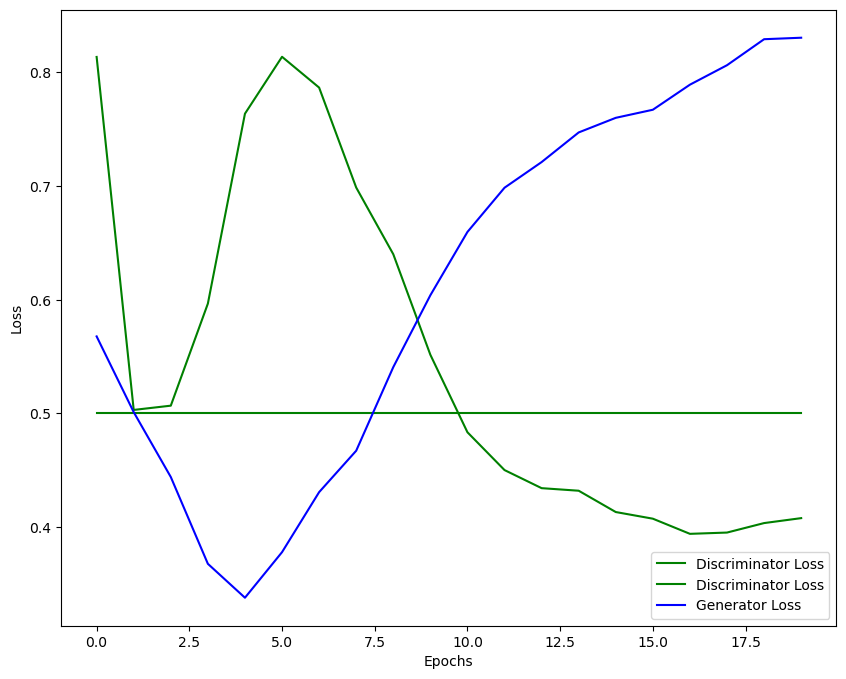

Total progress: 100%|██████████████████████████████████████████████████████████████████| 20/20 [24:20<00:00, 73.01s/it]


In [55]:
fit()

In [ ]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install opencv-python
# !pip list